# Detectron - Computer Vision

## Importation des librairies

In [1]:
import util
import os
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
import matplotlib.pyplot as plt
import cv2
import random
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import torch
import fiftyone as fo




## Lecture des classes

In [2]:
with open('class.names', 'r') as reader:
        classes_ = [l[:-1] for l in reader.readlines()]


## Préparation des données d'évaluations

In [3]:

#dataset_train_dict = util.get_dicts(os.path.join('data', 'train', 'imgs'), os.path.join('data', 'train', 'anns'))
dataset_valid_dict = util.get_dicts(os.path.join('data', 'val', 'imgs'), os.path.join('data', 'val', 'anns'))

## Instanciation des modèles

In [4]:
# On instancie le modèle de détection Detectron2 préalablement entraîné 
device = 'cpu'

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/retinanet_R_101_FPN_3x.yaml'))
cfg.MODEL.WEIGHTS = './output/model_final.pth'
cfg.MODEL.DEVICE = device


detection = DefaultPredictor(cfg)

Loading config /Users/charafaissaoui/miniforge3/envs/torch/lib/python3.11/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [14]:
# On instancie le modèle de classifictaion ainsi que les transformations associées
num_classes = len(classes_)
device = 'cpu'

classifier = util.Classifier(num_classes)
classifier.to(device)
classifier.load_state_dict(torch.load('./vaid_classifier.pth', map_location=torch.device('cpu'))) # map_location=torch.device('cpu') permet de charger un modèle entrainer avec cuda sur un cpu
classifier.eval()

# Les transformations des véhicules détectés avnat classification sont et doivent les mêmes que celles utilisées lors de l'entrainement du modèles.
transformes = util.get_transform()


/Users/charafaissaoui/miniforge3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/charafaissaoui/miniforge3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Visualisation des détections sur une image

In [15]:
# Fonction qui permet de visualiser les prédictions grâce aux packages Detectron2
def visualize_prediction(image, classes_, outputs_final):
    v = Visualizer(image, MetadataCatalog.get('train').set(thing_classes=classes_), scale=1.2)
    out = v.draw_instance_predictions(outputs_final.to('cpu'))
    plt.figure(figsize=(20,10))
    plt.axis("off")
    plt.imshow(cv2.cvtColor(out.get_image()[..., ::-1][..., ::-1], cv2.COLOR_BGR2RGB))


/Users/charafaissaoui/miniforge3/envs/torch/lib/python3.11/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3491.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


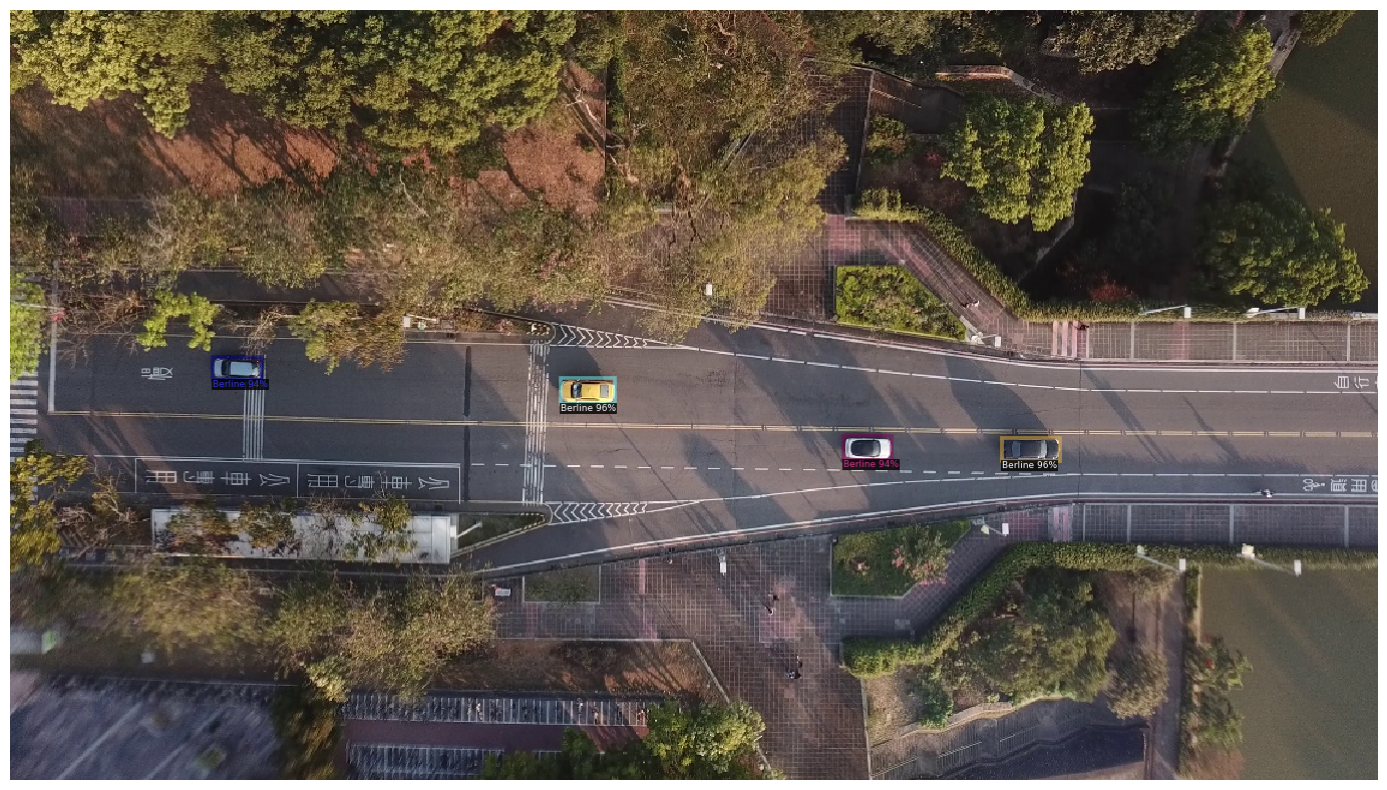

In [16]:
# On prends un image au hasard dans le dossier 'val' pour la détection
images = "./data/val/imgs/"
#idimage = "test.JPG"

id = random.choice(os.listdir(images))
idimage = os.path.join(images, id)
image = cv2.imread(idimage)

# On applique les deux modèles sur l'image, le premier va détecter les véhicules, le seconds va classifier les détections
outputs_final = util.prediction(image, classifier, detection, transformes, device)


# On affiche les prédictions
visualize_prediction(image, classes_,outputs_final)

## Extraction des véhicules détectés

In [17]:
import matplotlib.pyplot as plt
import math


# Fonction qui permet d'extraire les prédictions pour les afficher séparémment dans un grid
def generate_roi_grid(roi_list, pred_classes_final, classe_name, im):
    num_images = len(roi_list)
    num_cols = int(math.ceil(math.sqrt(num_images)))
    num_rows = int(math.ceil(num_images / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        if i < num_images:
            roi = roi_list[i]
            x1, y1, x2, y2 = roi.tolist()
            roi = im[int(y1):int(y2), int(x1):int(x2)]
            ax.imshow(roi)
            ax.axis('off')
            ax.set_title(classe_name[pred_classes_final[i]])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.suptitle('Véhicule(s) détecté(s)') 
    plt.show()


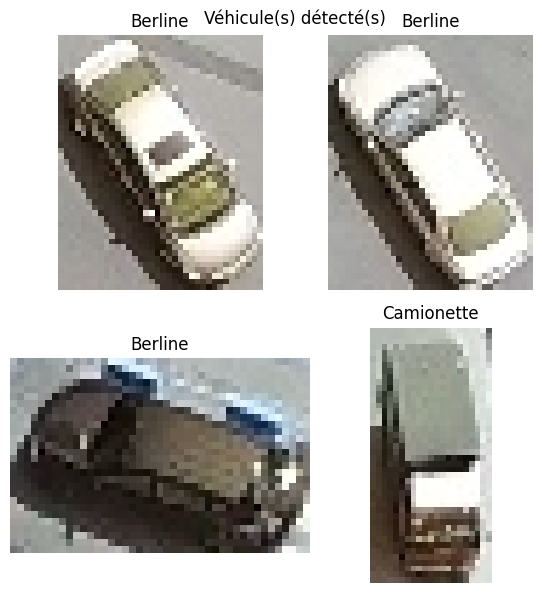

In [ ]:
# On récupère les zones de prédictions et leur labels associés
rois = outputs_final.pred_boxes.tensor
pred_classes_final = outputs_final.pred_classes

# On s'affiche le tout
generate_roi_grid(rois, pred_classes_final, classes_, image)


## Chargement des données dans le package Fiftyone

In [8]:
# Créer une liste pour stocker les échantillons
samples = []

# Parcourir les éléments du dataset
for data in dataset_valid_dict:
    # Chemin de l'image
    image_path = data['file_name']
    # Dimensions de l'image
    height = data['height']
    width = data['width']

    # Annotations
    annotations = data['annotations']

    # Convertir les annotations en format FiftyOne
    detections = []
    for annotation in annotations:
        # Extraire les informations d'annotation
        bbox = annotation['bbox']
        label = annotation['category_id']
        bbox_mode = annotation['bbox_mode']

        if bbox_mode == 1:  # XYWH_ABS
            # Convertir les coordonnées absolues en format top-left-x, top-left-y, width, height normalisées
            x0 = bbox[0] / width
            y0 = bbox[1] / height
            w = bbox[2] / width
            h = bbox[3] / height
            # Ajouter une détection à la liste
            detections.append(fo.Detection(label=str(label), bounding_box=[x0, y0, w, h]))

    # Créer un échantillon avec l'image et les détections
    sample = fo.Sample(filepath=image_path, id = "test")
    sample["ground_truth"] = fo.Detections(detections=detections)
    # Ajouter l'échantillon à la liste
    samples.append(sample)

# Créer le dataset
dataset = fo.Dataset("Evaluation VAID 3")
dataset.add_samples(samples)

dataset


 100% |███████████████| 1197/1197 [1.1s elapsed, 0s remaining, 1.1K samples/s]         


Name:        Evaluation VAID 3
Media type:  image
Num samples: 1197
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

In [9]:
def get_fiftyone_dicts(samples):
    # Calcule les métadonnées pour chaque échantillon dans l'ensemble de données
    samples.compute_metadata()

    # Initialise une liste vide pour stocker les dictionnaires de l'ensemble de données
    dataset_dicts = []
    
    # Itère sur chaque échantillon dans l'ensemble de données, en sélectionnant seulement les champs "id" et "filepath"
    for sample in samples.select_fields(["id", "filepath"]):

        # Initialise un dictionnaire vide pour l'enregistrement
        record = {}
        
        # Stocke le chemin du fichier et l'ID de l'échantillon dans le dictionnaire d'enregistrement
        record["file_name"] = sample.filepath
        record["image_id"] = sample.id

        # Ajoute le dictionnaire d'enregistrement à la liste des dictionnaires de l'ensemble de données
        dataset_dicts.append(record)

    # Renvoie la liste des dictionnaires de l'ensemble de données
    return dataset_dicts


In [13]:
def detectron_to_fo(outputs, img_w, img_h):
    # Initialise une liste vide pour stocker les détections
    detections = []
    
    # Convertit les sorties du modèle en CPU pour le traitement
    instances = outputs.to("cpu")
    
    # Itère sur chaque boîte de prédiction, score et classe prédite
    for pred_box, score, c in zip(
        instances.pred_boxes, instances.scores, instances.pred_classes, 
    ):
        # Récupère les coordonnées de la boîte de prédiction
        x1, y1, x2, y2 = pred_box
        
        # Normalise les coordonnées de la boîte de prédiction en divisant par la largeur et la hauteur de l'image
        # et convertit les coordonnées en format [tlx, tly, w, h]
        bbox = [float(x1)/img_w, float(y1)/img_h, float(x2-x1)/img_w, float(y2-y1)/img_h]
        
        # Crée une détection avec la classe prédite, le score de confiance et la boîte de prédiction
        detection = fo.Detection(label=str(int(c)+1), confidence=float(score), bounding_box=bbox)
        
        # Ajoute la détection à la liste des détections
        detections.append(detection)

    # Convertit la liste des détections en un objet Detections de FiftyOne et le renvoie
    return fo.Detections(detections=detections)


In [18]:
# Récupère les dictionnaires de l'ensemble de données en utilisant la fonction get_fiftyone_dicts
dataset_dicts = get_fiftyone_dicts(dataset)

# Initialise un dictionnaire vide pour stocker les prédictions
predictions = {}

# Itère sur chaque dictionnaire dans dataset_dicts
for d in dataset_dicts:
    # Définit la largeur et la hauteur de l'image
    img_w = 1137
    img_h = 640
    
    # Lit l'image à partir du chemin du fichier
    img = cv2.imread(d["file_name"])
    
    # Obtient les prédictions en utilisant la fonction util.prediction
    outputs = util.prediction(img, classifier, detection, transformes, device)
    
    # Convertit les prédictions de Detectron en un format compatible avec FiftyOne
    detections = detectron_to_fo(outputs, img_w, img_h)
    
    # Stocke les détections dans le dictionnaire de prédictions en utilisant l'ID de l'image comme clé
    predictions[d["image_id"]] = detections

# Définit les valeurs de la colonne "predictions" de l'ensemble de données en utilisant le dictionnaire de prédictions
# L'argument key_field spécifie que l'ID de l'image doit être utilisé comme clé pour associer chaque prédiction à l'échantillon correspondant
dataset.set_values("predictions", predictions, key_field="id")


## Evaluation des données de test

In [19]:
view = dataset.map_labels("ground_truth", {"1": "Berline", "2": "Minibus", "3" : "Camionette", "4": "Remorque", "5" : "Bus", "6" : "Camion Ciment", "7": "Poids lourd"})
view.save()
view = dataset.map_labels("predictions", {"1": "Berline", "2": "Minibus", "3" : "Camionette", "4": "Remorque", "5" : "Bus", "6" : "Camion Ciment", "7": "Poids lourd"})
view.save()

dataset.save()

In [20]:
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)


Evaluating detections...
 100% |███████████████| 1197/1197 [12.1s elapsed, 0s remaining, 97.3 samples/s]       
Performing IoU sweep...
 100% |███████████████| 1197/1197 [8.3s elapsed, 0s remaining, 163.5 samples/s]      


### Intersection over Union

In [27]:
import numpy as np 

ious = results.ious

ious_np = np.array([iou if iou is not None else np.nan for iou in ious])

mean_iou = np.nanmean(ious_np)

print("Moyenne IoU:", mean_iou)

Moyenne IoU: 0.8693976645534367


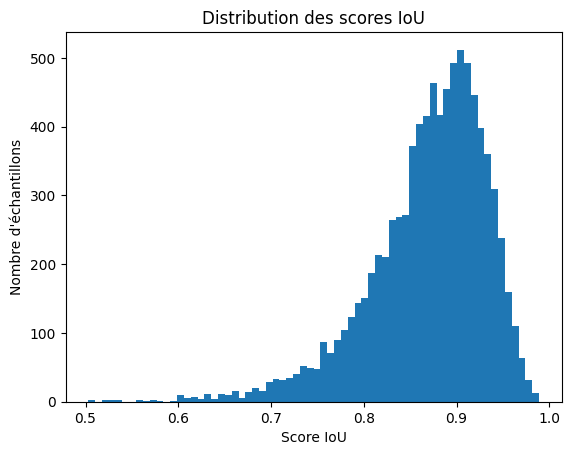

In [28]:
ious_np = ious_np[~np.isnan(ious_np)]

plt.hist(ious_np, bins='auto') 

plt.title('Distribution des scores IoU')
plt.xlabel('Score IoU')
plt.ylabel('Nombre d\'échantillons')

plt.show()

### Mean Average Precision

In [29]:
results.mAP()

0.7463475459569252

### Rapport de classification

In [30]:
results.print_report()

               precision    recall  f1-score   support

      Berline       0.96      0.96      0.96      7543
          Bus       0.96      0.96      0.96       114
Camion Ciment       0.89      1.00      0.94        41
   Camionette       0.93      0.94      0.93       607
      Minibus       0.97      0.97      0.97        95
  Poids lourd       0.93      0.94      0.94       150
     Remorque       0.92      0.95      0.93       625

    micro avg       0.96      0.96      0.96      9175
    macro avg       0.94      0.96      0.95      9175
 weighted avg       0.96      0.96      0.96      9175



### Precision-Recall Curve

In [31]:
curve = results.plot_pr_curves(classes=["Berline", "Minibus", "Camionette", "Remorque", "Bus", "Camion Ciment", "Poids lourd"])
curve.save('curve.jpeg')

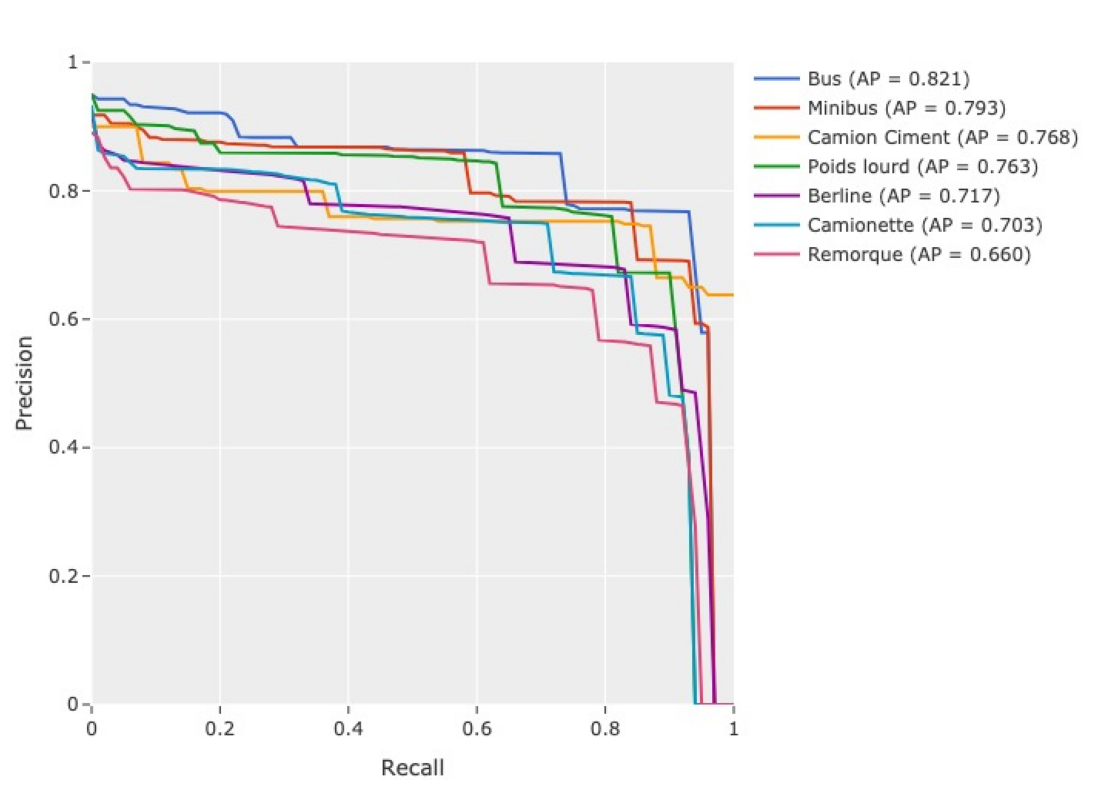

In [32]:
image = Image.open("curve.jpeg")
plt.figure(figsize=(16,10))
plt.imshow(image)
plt.axis('off')
plt.show()



## Visualisation des données grâce au package Fiftyone

In [33]:
dataset = fo.load_dataset("Evaluation VAID")
session = fo.launch_app(dataset)


In [27]:
session.freeze()